In [40]:
import numpy as np
import json
import pandas as pd
import matplotlib.pyplot as plt
import GPy
import collections

In [17]:
num_account = 50000
losses_account_array_single = []
index_array = []
for i in range(num_account):
    f = open("../smallAccount-1/account_" + str(i) + ".json", "r")
    temp = json.load(f)
    if len(temp['hazard']['perils'][0]["locations"]) == 1:
        losses_account_array_single.append(temp)
        index_array.append(i)

In [139]:
x_data = []
y_data = []
periods_data = []
year_bulids_array = []
num_floor_array = []
bsum_array = []
bisum_array = []
csum_array = []
for index, losses_account in enumerate(losses_account_array_single):
    x = losses_account["exposure"]["locations"][0]["x"]
    y = losses_account["exposure"]["locations"][0]["y"]
    year = losses_account["exposure"]["locations"][0]["yearBuilt"]
    num_floor = losses_account["exposure"]["locations"][0]["numberFloors"]
    bsum = losses_account["exposure"]["locations"][0]['bsum']
    if "bisum" in losses_account["exposure"]["locations"][0]:
        bisum = losses_account["exposure"]["locations"][0]['bisum']
    else:
        bisum = 0
    if "csum" in losses_account["exposure"]["locations"][0]:
        csum = losses_account["exposure"]["locations"][0]['csum']
    else:
        csum = 0
    periods_data_temp = []
    for i in range(len(losses_account['hazard']['perils'][0]["locations"][0]['attributes_rp'][0]["return_periods"])):
        periods_data_temp.append(losses_account['hazard']['perils'][0]["locations"][0]['attributes_rp'][0]["return_periods"][i]['value'])
    periods_data.append(periods_data_temp)
    x_data.append(x)
    y_data.append(y)
    year_bulids_array.append(year)
    num_floor_array.append(num_floor)
    bsum_array.append(bsum)
    csum_array.append(csum)
    bisum_array.append(bisum)
periods_data = np.array(periods_data, dtype=np.float32)
x_data = np.array(x_data, dtype=np.float32)
y_data = np.array(y_data, dtype=np.float32)
year_bulids_array = np.array(year_bulids_array, dtype=np.float32)
num_floor_array = np.array(num_floor_array, dtype=np.float32)
bsum_array = np.array(bsum_array, dtype=np.int)
csum_array = np.array(csum_array, dtype=np.int)
bisum_array = np.array(bisum_array, dtype=np.int)

In [62]:
AAL_GU_array = []
EP_GU_array = []
for index in index_array:
    f = open("../results-1/losses_Account_" + str(index) + ".csv", "r")
    l = f.readlines()
    temp = l[1].split(",")
    AAL_GU_array.append(float(temp[1]))
    EP_GU_array.append(np.array([temp[i+3] for i in range(10)], dtype=np.float32))
AAL_GU_array = np.array(AAL_GU_array, dtype=np.float32)
EP_GU_array = np.array(EP_GU_array, dtype=np.float32)

In [69]:
collections.Counter(csum_array)

Counter({100000000.0: 651,
         0.0: 12824,
         2000000.0: 657,
         10000000.0: 659,
         1000000.0: 598,
         500000.0: 640})

In [140]:
collections.Counter(bisum_array)

Counter({0: 14395,
         500000: 344,
         100000000: 321,
         1000000: 317,
         10000000: 323,
         2000000: 329})

In [71]:
collections.Counter(bsum_array)

Counter({1000000.0: 3128,
         500000.0: 3176,
         100000000.0: 3280,
         10000000.0: 3270,
         2000000.0: 3175})

In [ ]:
logic_array = np.logical_and(csum_array == 0, bisum_array == 0)
logic_array = np.logical_and(logic_array, bsum_array == 1000000.0)
logic_array = np.array(logic_array, dtype=np.int0)
logic_array_2 = np.logical_and(csum_array == 0, bisum_array == 100000000.0)
logic_array_2 = np.logical_and(logic_array_2, bsum_array == 1000000.0)
logic_array_2 = np.array(logic_array_2, dtype=np.int0)*2
color = np.array(["red", "blue", "green"])
alpha = np.array([0.0, 0.5,0.5])

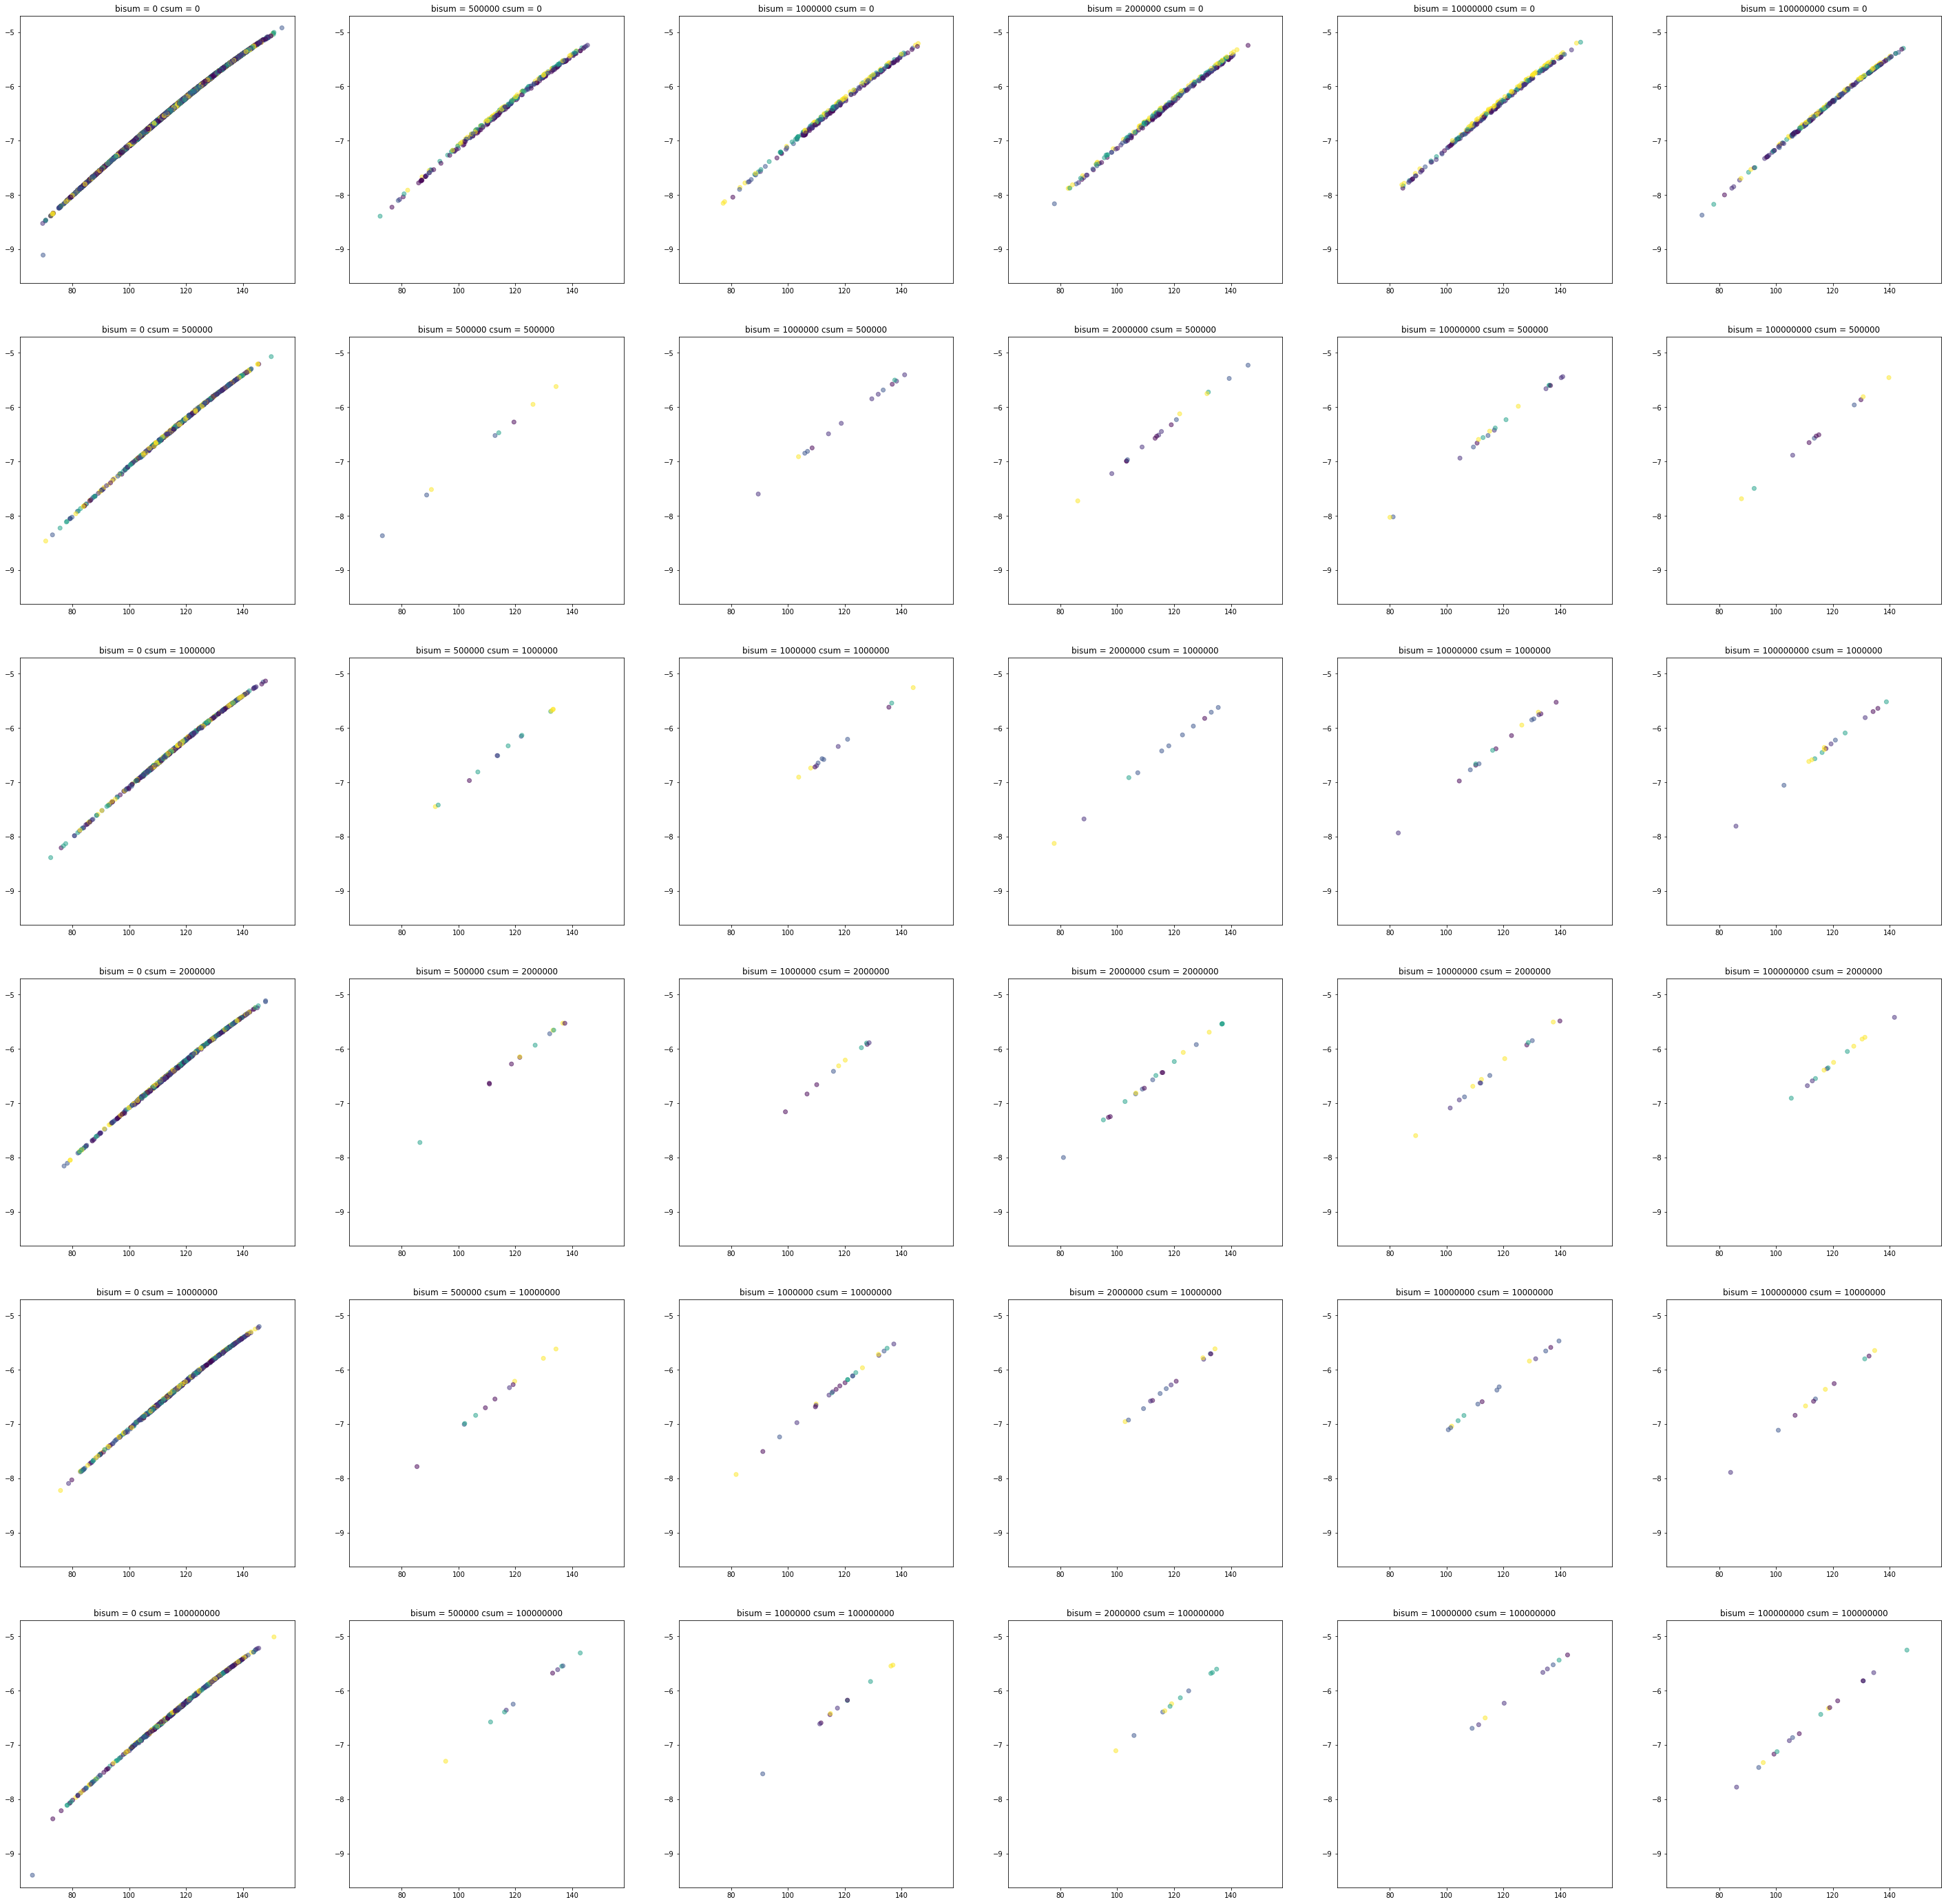

In [188]:
# c_sum_array == 0 and b_sum_array == 0 となるlogic値
count_bsum = collections.Counter(bsum_array)
count_bisum = collections.Counter(bisum_array)
count_csum = collections.Counter(csum_array)
key_bsum = list(count_bsum.keys())
key_bisum = list(count_bisum.keys())
key_csum = list(count_csum.keys())
key_bsum = np.sort(key_bsum)
key_bisum = np.sort(key_bisum)
key_csum = np.sort(key_csum)
pair_matrix = np.zeros((len(count_bisum), len(count_csum),2))
for i in range(len(count_bisum)):
    for j in range(len(count_csum)):
        pair_matrix[i][j][0] = count_bisum[i]
        pair_matrix[i][j][1] = count_csum[j]
fig, axs = plt.subplots(len(count_bisum), len(count_csum), figsize=(50, 50))
for i in range(len(count_bisum)):
    for j in range(len(count_csum)):
        logic_array = np.logical_and(csum_array == key_csum[i], bisum_array == key_bisum[j])
        # logic_array = np.logical_and(logic_array, bsum_array == 1000000)
        logic_array = np.array(logic_array, dtype=np.int0)
        axs[i,j].scatter(periods_data[:, 1], np.log(AAL_GU_array/(bsum_array  + 2*bisum_array + 0.7*csum_array)), c = np.log(bsum_array),alpha = alpha[logic_array])
        axs[i,j].set_title("bisum = " + str(key_bisum[j]) + " csum = " + str(key_csum[i]))


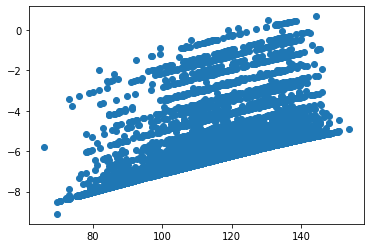

In [229]:
plt.scatter(periods_data[:, 1], np.log(AAL_GU_array/(bsum_array)))

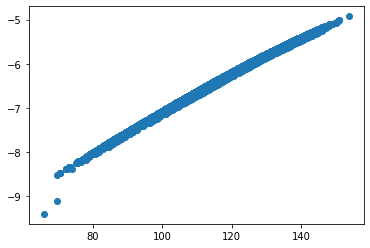

In [228]:
plt.scatter(periods_data[:, 1], np.log(AAL_GU_array/(bsum_array + 0.7*csum_array + 2*bisum_array)))

In [226]:
#1次元のガウス過程回帰
new_array  = bsum_array + 0.7*csum_array + 2*bisum_array
kernel = GPy.kern.RBF(input_dim=9, variance=1., lengthscale=1.)
x = periods_data[:, :]
y = np.log(AAL_GU_array/new_array)
x_train = x[:1000]
y_train = y[:1000]
m = GPy.models.GPRegression(x_train[:], y_train[:, None], kernel)
m.optimize(messages=True)

In [227]:
y_pred, y_var = m.predict(x[1000:], full_cov=False)
y_pred = np.exp(y_pred)
#relative error
np.linalg.norm(y_pred.T - AAL_GU_array[1000:]/new_array[1000:])/np.linalg.norm(AAL_GU_array[1000:]/new_array[1000:])

0.014504743488516405

In [335]:
#alphaとbetaの最適化
kernel = GPy.kern.RBF(input_dim=9, variance=1., lengthscale=1.)
x = periods_data[:, :]
y = np.log(AAL_GU_array/bsum_array)
x_train = x[:2000]
y_train = y[:2000]
index_use = np.logical_and(bisum_array[:2000] == 0, csum_array[:2000] == 0)
x_train_temp = x_train[index_use]
y_train_temp = y_train[index_use]
m = GPy.models.GPRegression(x_train_temp[:], y_train_temp[:, None], kernel)
m.optimize(messages=True)
def f(alpha, beta, gamma):
    new_array = gamma*bsum_array + beta*csum_array + alpha*bisum_array
    y_pred = np.exp(m.predict(x_train)[0].T)
    return np.linalg.norm(y_pred - AAL_GU_array[:2000]/new_array[:2000])/np.linalg.norm(AAL_GU_array[:2000]/new_array[:2000])

In [336]:
#最適化
from scipy.optimize import minimize
res = minimize(lambda x: f(x[0], x[1], x[2]), [0.7, 2, 1])
res.x

array([1.85692946, 0.69109812, 1.00000059])

In [337]:
f(1.85692946,0.69109812,1.00000059)

2.9310805664266264e-05

In [338]:
#1次元のガウス過程回帰
new_array  = 1.00000059*bsum_array + 0.69109812*csum_array + 1.85692946*bisum_array
kernel = GPy.kern.RBF(input_dim=9, variance=1., lengthscale=1.)
x = periods_data[:, :]
y = np.log(AAL_GU_array/new_array)
x_train = x[:2000]
y_train = y[:2000]
m = GPy.models.GPRegression(x_train[:], y_train[:, None], kernel)
m.optimize(messages=True)

In [340]:
y_pred, y_var = m.predict(x[2000:], full_cov=False)
y_pred = np.exp(y_pred)
#relative error
np.linalg.norm(y_pred.T - AAL_GU_array[2000:]/new_array[2000:])/np.linalg.norm(AAL_GU_array[2000:]/new_array[2000:])

0.00042314011155453055

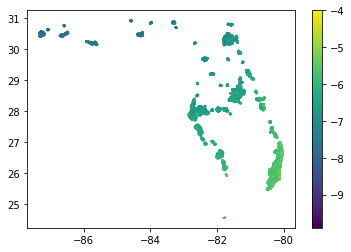

In [322]:
plt.scatter(x_data[1000:], y_data[1000:], c = np.array(np.log(AAL_GU_array[1000:]/new_array[1000:]), dtype=np.float32), s = 1,vmin=-4, vmax=-9)
plt.colorbar()

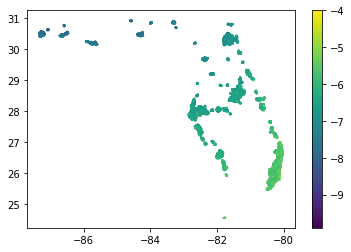

In [323]:
plt.scatter(x_data[1000:], y_data[1000:], c = np.array(np.log(y_pred), dtype=np.float32), s = 1,vmin=-4, vmax=-9)
plt.colorbar()

 /var/folders/84/qlhr41xn3lsb9qd471xyrmcm0000gn/T/ipykernel_36134/1692848761.py:1: RuntimeWarning:invalid value encountered in log


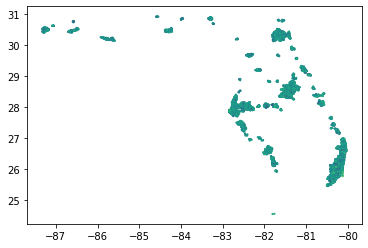

In [331]:
plt.scatter(x_data[1000:], y_data[1000:], c = np.log(np.array(y_pred.T - AAL_GU_array[1000:]/new_array[1000:] , dtype=np.float32)), s = 1)

In [328]:
np.max(y_pred.T - AAL_GU_array[1000:]/new_array[1000:])

8.995434368602621e-05

In [329]:
np.min(y_pred.T - AAL_GU_array[1000:]/new_array[1000:])

-3.700081974836785e-07